<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Assignment_3_Evolutionary_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
pip install ucimlrepo

In [ ]:
pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=47bf79f43677613b84da74fcafd7810a413ffdef43a23c57ba2e5de002789058
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [ ]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
import statistics

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

# data (as pandas dataframes)
X = taiwanese_bankruptcy_prediction.data.features
y = taiwanese_bankruptcy_prediction.data.targets

# Dataset Cleaning and Preprocessing

In [ ]:
features = X.copy()

# Check for null values
print("Columns with null value")
print("-----------------------------------")
print("{:15} {:15}".format("Column","Num of null values"))
for col in features.columns:
  number_of_null_values = features[col].isna().sum()
  if number_of_null_values > 0:
    print(col)
    print("{:-15} {:-15}".format(col,number_of_null_values))

Columns with null value
-----------------------------------
Column          Num of null values


In [ ]:
# Check for col with object dtype
features.select_dtypes('object').columns

Index([], dtype='object')

In [ ]:
features.select_dtypes('int').columns

Index([' Liability-Assets Flag', ' Net Income Flag'], dtype='object')

In [ ]:
print("Unique value of Liability-Assets Flag : ", features[' Liability-Assets Flag'].unique())
print("Unique value of Net Income Flag : ", features[' Net Income Flag'].unique())

Unique value of Liability-Assets Flag :  [0 1]
Unique value of Net Income Flag :  [1]


In [ ]:
print("Number of Liability-Assets Flag == 0 : ",len(features[features[' Liability-Assets Flag'] == 0]))
print("Number of Liability-Assets Flag == 1 : ",len(features[features[' Liability-Assets Flag'] == 1]))

Number of Liability-Assets Flag == 0 :  6811
Number of Liability-Assets Flag == 1 :  8


In [ ]:
features.drop(columns = features.select_dtypes('int').columns,inplace = True)

In [ ]:
# Imbalance Dataset
print("Number of Bankrupt == 0 : " , len(y[y['Bankrupt?'] == 0]))
print("Number of Bankrupt == 1 : " , len(y[y['Bankrupt?'] == 1]))

Number of Bankrupt == 0 :  6599
Number of Bankrupt == 1 :  220


In [ ]:
df = pd.concat([features,y],axis = 1)
df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490,1


In [ ]:
# Upsampling
features_majority = df[df['Bankrupt?'] == 0]
features_minority = df[df['Bankrupt?'] == 1]

features_minority_upsample = resample(
    features_minority,
    replace = True,
    n_samples = len(features_majority),
    random_state = 123
)

df = pd.concat([features_majority,features_minority_upsample])

print("Number of rows of features dataframe : ", len(df))
print("Number of Bankrupt == 0 : " , len(df[df['Bankrupt?'] == 0]))
print("Number of Bankrupt == 1 : " , len(df [df['Bankrupt?'] == 1]))

df.head()

Number of rows of features dataframe :  13198
Number of Bankrupt == 0 :  6599
Number of Bankrupt == 1 :  6599


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
6,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,0.781180,...,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,0.015663,0
7,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,0.781621,...,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,0.034889,0
8,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,0.781598,...,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,0.065826,0
9,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,0.781574,...,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,0.030801,0
10,0.482475,0.567543,0.538198,0.614026,0.614026,0.998978,0.797535,0.809460,0.303759,0.781629,...,0.814111,0.076972,0.623687,0.614021,0.841337,0.278356,0.026971,0.565892,0.036572,0


In [ ]:
# Split Dataset into train and test sets
X = df.drop(['Bankrupt?'],axis = 1)
y = df['Bankrupt?']
X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

print("Training features : ", len(X_train))
print("Testing features  : ", len(X_test))
print("Training labels   : ", len(y_train))
print("Testing labels    : ", len(y_test))

Training features :  10558
Testing features  :  2640
Training labels   :  10558
Testing labels    :  2640


# Features Selection - GA algorithms

In [ ]:
# Define a function to evaluate the fitness of a feature subset
def feature_selection_fitness_function(features):
  X_train_subset = X_train[features]
  X_test_subset = X_test[features]
  clf = RandomForestClassifier(random_state = 42)
  clf.fit(X_train_subset,y_train)
  return clf.score(X_test_subset,y_test)

In [5]:
def fitness_function(individual,data,target):
  # Filter the features based on the individual's chromosome
  selected_features = [feature for feature,bit in zip(data.columns,individual) if bit == 1]
  X = data[selected_features]
  model = RandomForestRegressor(random_state = 42)
  model.fit(X,target)
  return model.score(X_test[selected_features],y_test)

# def init_individual(icls,size,num_features):
#   individual = [0] * size
#   ones_indices = random.sample(range(size),num_features)
#   for idx in ones_indices:
#     individual[idx] = 1
#   return icls(individual)

def feature_selection_genetic_algo(data,features,target,population_size,num_generations):
  # Create the Fitness and Individual classes
  creator.create("FitnessMin",base.Fitness,weights = (-1.0,))
  creator.create("Individual",list,fitness = creator.FitnessMin)

  # Initialize the toolbox
  toolbox = base.Toolbox()

  # toolbox.register('individual',init_individual,creator.Individual,size = len(features),num_features = 10)
  # toolbox.register('population',tools.initRepeat,list,toolbox.individual)

  # Attribute generator: Define a function to randomly generate a feature selector (0 or 1)
  toolbox.register('attr_bool',random.randint,0,1)

  # Register the evaluation function
  toolbox.register("evaluate",fitness_function,data = data,target = target)
  toolbox.register('mate',tools.cxTwoPoint)
  toolbox.register('mutate',tools.mutFlipBit,indpb = 0.05)
  toolbox.register('select',tools.selTournament,tournsize  = 3)

  # Initialize population
  population = toolbox.population(n = population_size)

  fitnesses = list(map(toolbox.evaluate,population))

  for ind,fit in zip(population,fitnesses):
    ind.fitness.values = fit

  # Variable keeping track of the number of generations
  gen = 0

  while gen < num_generations:
    gen+=1
    print("Generation : ",gen)

    # Select the next generation individuals
    offspring = toolbox.select(population,len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone,offspring))

    # Apply crossover and mutation on the offspring
    for child1,child2 in zip(offspring[::2],offspring[1::2]):
      if random.random() < 0.5:
        toolbox.mate(child1,child2)
        del child1.fitness.values
        del child2.fitness.values

    for mutant in offspring:
      if random.random() < 0.2:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

    fitnesses = map(toolbox.evaluate,invalid_ind)

    for ind,fit in zip(invalid_ind,fitnesses):
      ind.fitness.values = fit

    # Replace the population with the offspring
    population[:] = offspring

  # Find the best individual
  best_ind = tools.selBest(population,1)[0]

  # Select the top 10 features from the best individual
  selected_features = [features[i] for i in range(len(best_ind)) if best_ind[i] == 1]

  if len(selected_features) > 10:
    X = data[selected_features]
    model = RandomForestClassifier()
    model.fit(X,target)
    feature_importances = model.feature_importances_
    important_features = sorted(zip(selected_features,feature_importances),key = lambda x : x[1],reverse = True)
    best_features = [feature for feature,importance in important_features[:10]]
  else:
    best_features = selected_features

  return best_features

In [ ]:
features = X_train.columns
population_size = 5
tol_level = 0.01
top_number = 5
best_features, best_f1_score = genetic_algo(X_train, X_train.columns, y_train,population_size, tol_level, top_number)

print("Best Features:", best_features)
print("Best F1 Score:", best_f1_score)

Generation: 1
Variance of Population:  9.847611108955425e-08
Best Features: [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' Pre-tax net Interest Rate', ' Tax rate (A)', ' Net Value Per Share (A)', ' Persistent EPS in the Last Four Seasons', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Operating Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Cash Reinvestment %', ' Current Ratio', ' Quick Ratio', ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets', ' Contingent liabilities/Net worth', ' Net profit before tax/Paid-in capital', ' Inventory and accounts receivable/Net value', ' Average Collection Days', ' Inventory Turnover Rate (times)', ' Quick Assets/Total Assets', ' Cash/Current Liability', ' Current Liability to Assets', ' Operating Funds to Liability', ' Inventory/Working Capital', ' Inventory/Current L

# Fuzzy Logic Design

In [ ]:
class Fuzzify():
  def __init__(self,data_series,min,max,mid):
    self.data = data_series
    self.min = min
    self.mid = mid
    self.max = max
    self.universe = np.arange(np.floor(self.min),np.ceil(self.max) + 0.1,0.1)
    self.trimf_min = fuzz.trimf(self.universe,[self.min,self.min,self.mid])
    self.trimf_mid = fuzz.trimf(self.universe,[self.min,self.mid,self.max])
    self.trimf_max = fuzz.trimf(self.universe,[self.mid,self.max,self.max])

  def universe(self):
    return self.universe

  def get_membership(self):
    membership_df = pd.DataFrame(self.data,columns = ['data'])
    membership_df['min'] = fuzz.interp_membership(self.universe,self.trimf_min,self.data)
    membership_df['mid'] = fuzz.interp_membership(self.universe,self.trimf_mid,self.data)
    membership_df['max'] = fuzz.interp_membership(self.universe,self.trimf_max,self.data)
    membership_df['membership'] = membership_df[:,['min','mid','max']].idxmax(axis = 1)
    membership_df['degree'] = membership_df[:,['min','mid','max']].max(axis = 1)
    print(membership_df)

In [ ]:
def define_fuzzy_input_variable(dataset):
    membership_functions = []

    for col in dataset.columns[:10]:
        min_val = np.min(dataset[col])
        max_val = np.max(dataset[col])
        mid_val = np.median(dataset[col])

        # Define the universe with reduced precision to save memory
        universe = np.arange(np.floor(min_val), np.ceil(max_val) + 0.1, 0.5)

        feature = ctrl.Antecedent(universe, str(col))
        feature['min'] = fuzz.trimf(feature.universe, [min_val, min_val, mid_val])
        feature['mid'] = fuzz.trimf(feature.universe, [min_val, mid_val, max_val])
        feature['max'] = fuzz.trimf(feature.universe, [mid_val, max_val, max_val])

        membership_functions.append(feature)


    return membership_functions

In [ ]:
membership_functions = define_fuzzy_input_variable(X_train)

In [ ]:
len(membership_functions)

10

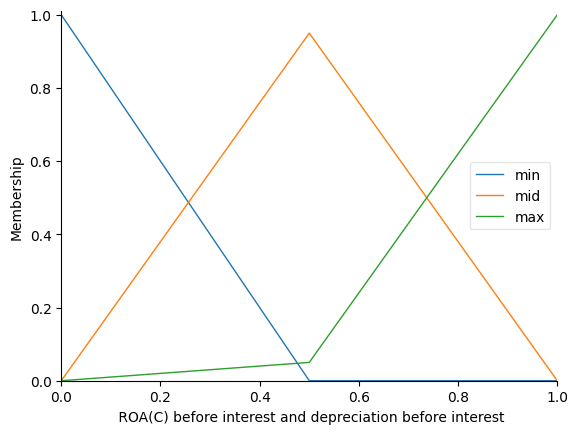

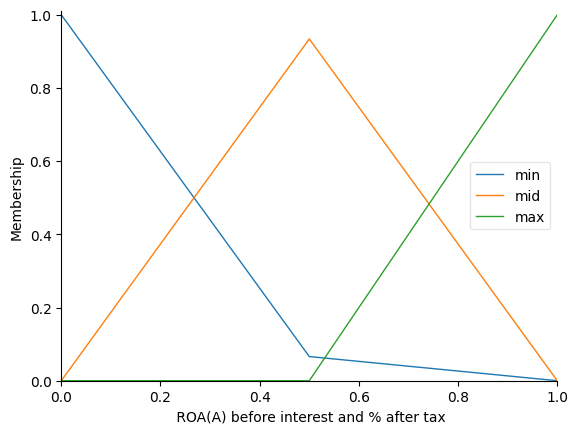

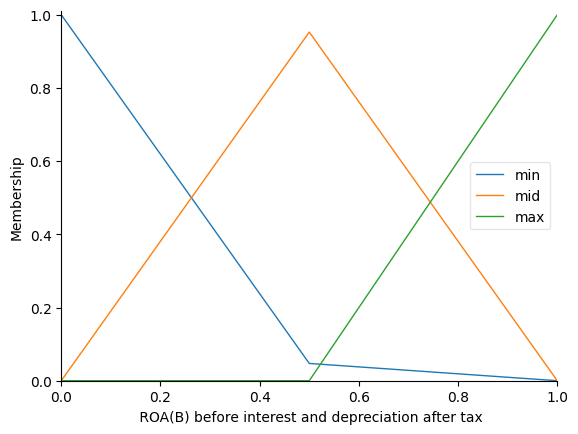

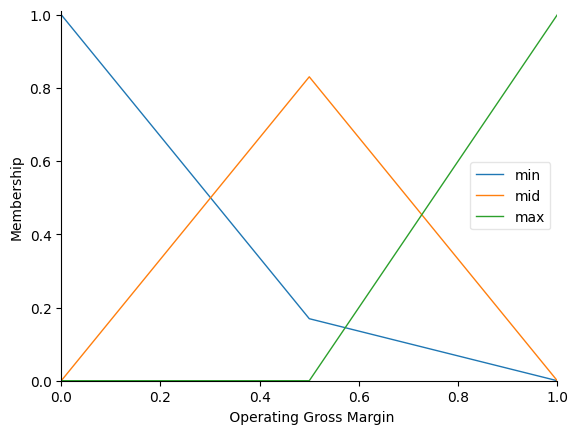

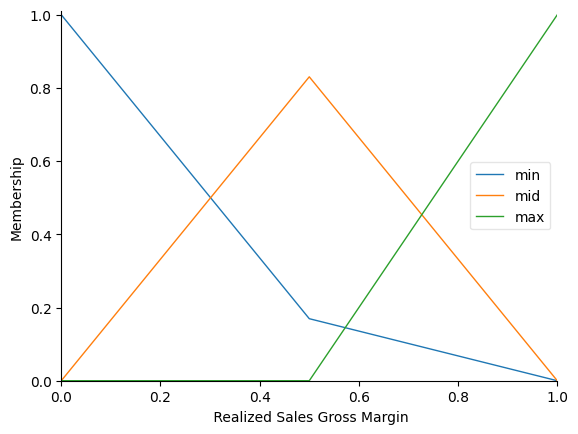

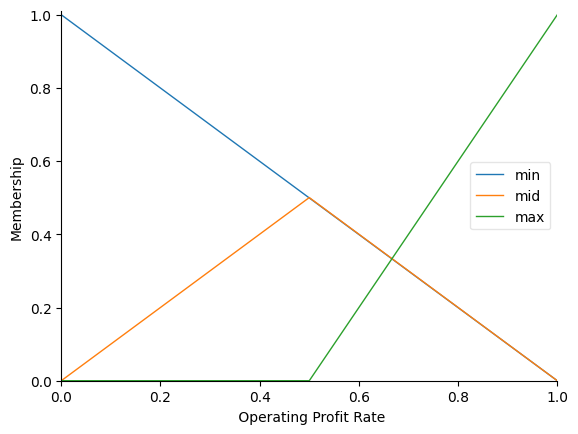

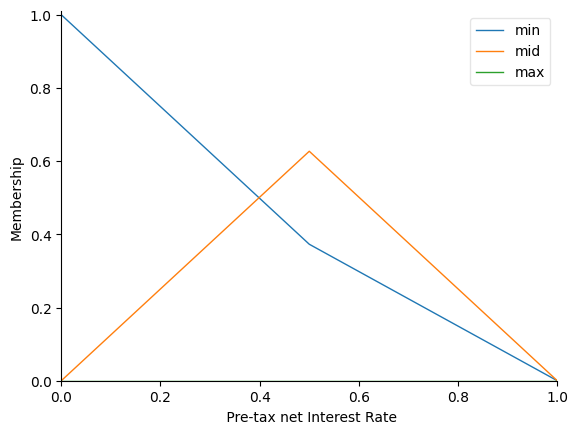

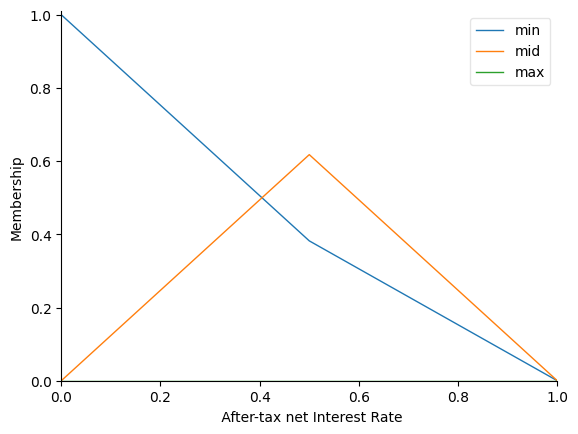

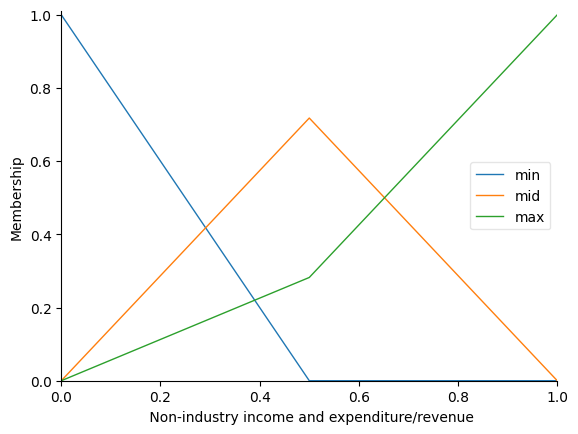

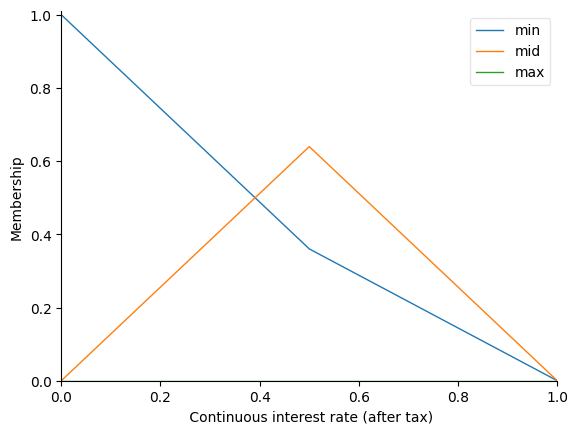

In [ ]:
for i in range(len(membership_functions)):
  membership_functions[i].view()